# Compare Models to Select the Best Hyperparameters
This tutorial will review **[AMPL](https://github.com/ATOMScience-org/AMPL)** functions for visualizing the results of a hyperparameter search in order to find the optimal hyperparameters for your model.

After performing a hyperparameter search, it is prudent to examine each hyperparameter in order to determine the best combination before training a production model with all of the data. Additionally, it is good to explore multiple performance metrics and visualize the predictions instead of relying solely on metrics.

For the purposes of this tutorial, we simply ran **Tutorial 5, "Hyperparameter Optimization"**, with different parameters such as those outlined **[here](https://github.com/ATOMScience-org/AMPL#hyperparameter-optimization)** to get enough models for comparison. Specifically, we created additional **NN** and  **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** models as well as using **fingerprint** and **scaffold splits**. If you don't want to run that many models, you can use the `result_df` saved here: `dataset/SLC6A3_models/07_example_pred_df.csv`.

In this tutorial, we will focus on these functions:

* [plot_train_valid_test_scores](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.plot_train_valid_test_scores)
* [plot_split_perf](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.plot_split_perf)
* [plot_hyper_perf](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.plot_hyper_perf)
* [get_score_types](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.get_score_types)
* [plot_xg_perf](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.plot_xg_perf)
* [plot_pred_vs_actual_from_file](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_pred_vs_actual_from_file)


## Import Packages

In [14]:
from atomsci.ddm.pipeline import compare_models as cm
from atomsci.ddm.pipeline import hyper_perf_plots as hpp
from atomsci.ddm.pipeline import perf_plots as pp
import pandas as pd
pd.set_option('display.max_columns', None)

# ignore warnings in tutorials
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Get Model Results and Filter
First we pull the results of the hyperparameter search into a dataframe. In **Tutorial 5, "Hyperparameter Optimization"**, we used `get_filesystem_perf_results()` which packs hyperparameters in a dict in the column `model_parameters_dict`. Here we use the individual hyperparameter columns to create visualizations.  

The `result_df` used here as an example is the result of calling `get_filesystem_perf_results()` once after training several hundred models with different parameters. These models were all saved in a single folder, but the function works iteratively so it can search an entire directory tree if a parent folder is passed.

In [12]:
import atomsci.ddm.pipeline.compare_models as cm

# model_dir = f'/Users/echun/repos/DILI-rotation/AMPL_models/best_cluster_models/CellCount'
model_dir = f'../AMPL_models/DILI_models2DILI_models'

result_df = cm.get_filesystem_perf_results(
    result_dir = model_dir,
    pred_type='classification'
)

# sort by validation r2 score to see top performing models
# result_df = result_df.sort_values(by='best_valid_roc_auc_score', ascending=False)
# result_df[['model_uuid','model_parameters_dict','best_valid_roc_auc_score','best_test_roc_auc_score']].head()


Found data for 1300 models under ../AMPL_models/DILI_models2DILI_models


In [13]:
import pandas as pd
model_uuid = "ac5b824c-60c3-48e7-a7eb-7d1e69350448"
model_info = result_df[result_df["model_uuid"]==model_uuid]
pd.set_option('display.max_colwidth', 500)
print(model_info[['model_uuid',
                  'model_parameters_dict',
                  'best_valid_prc_auc_score',
                  'best_valid_roc_auc_score',
                  'best_valid_bal_accuracy',
                  'best_test_prc_auc_score',
                  'best_test_roc_auc_score',
                  'best_test_bal_accuracy']])


                               model_uuid  \
651  ac5b824c-60c3-48e7-a7eb-7d1e69350448   

                                                 model_parameters_dict  \
651  {"rf_estimators": 53, "rf_max_depth": 24, "rf_max_features": 105}   

     best_valid_prc_auc_score  best_valid_roc_auc_score  \
651                  0.854207                  0.770551   

     best_valid_bal_accuracy  best_test_prc_auc_score  \
651                 0.678955                 0.744855   

     best_test_roc_auc_score  best_test_bal_accuracy  
651                 0.722918                0.655723  


We can look at a brief count of models for important parameters by creating a pivot table. Here we can see **[ECFP fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t)** and **[RDKit](https://github.com/rdkit/rdkit)** features and **fingerprint** and **scaffold splitters** were used for each model type. A fingerprint splitter provides a more stringent test of model performance by making sure the validation and test compounds are structurally dissimilar to the training set compounds.

In [20]:
# model counts
model_counts=pd.DataFrame(result_df.groupby(['features','splitter','model_type'])['model_uuid'].count()).reset_index()
model_counts=model_counts.pivot(index='model_type',columns=['splitter','features',], values='model_uuid')
model_counts

splitter       scaffold                           
features   ch_chemberta ch_moe ch_mordred ch_rdkit
model_type                                        
NN                  100    100        100      100
RF                  100    100        100      100
xgboost             100    100        200      100

Often, certain random combinations of hyperparameters result in terribly performing models. Here we will filter those out so they don't affect the visualization by only keeping models with a validation `r2_score` of 0.1 or greater.

In [21]:
result_df.best_valid_roc_auc_score.describe()

count    1300.000000
mean        0.698377
std         0.046527
min         0.500000
25%         0.682168
50%         0.707486
75%         0.727207
max         0.770551
Name: best_valid_roc_auc_score, dtype: float64

In [22]:
# filter out objectively bad performing models
result_df=result_df[result_df.best_valid_roc_auc_score>0.2]
result_df.shape

(1300, 70)

In [23]:
# result_df.best_valid_prc_auc_score.describe()
# result_df.best_valid_accuracy_score.describe()

result_df=result_df[result_df.best_valid_accuracy_score>0.2]
result_df.shape

(1300, 70)

After filtering out models with extremely poor metrics, we can see that some combinations don't work at all, and are completely filtered from the set. For example, decision tree based models using **[RDKit](https://github.com/rdkit/rdkit)** or **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features work very poorly to predict on fingerprint-split models.

In [7]:
#  model counts
model_counts=pd.DataFrame(result_df.groupby(['features','splitter','model_type'])['model_uuid'].count()).reset_index()
model_counts=model_counts.pivot(index='model_type',columns=['splitter','features',], values='model_uuid')
model_counts

splitter,scaffold
features,cell_health
model_type,
NN,100
RF,100
xgboost,100


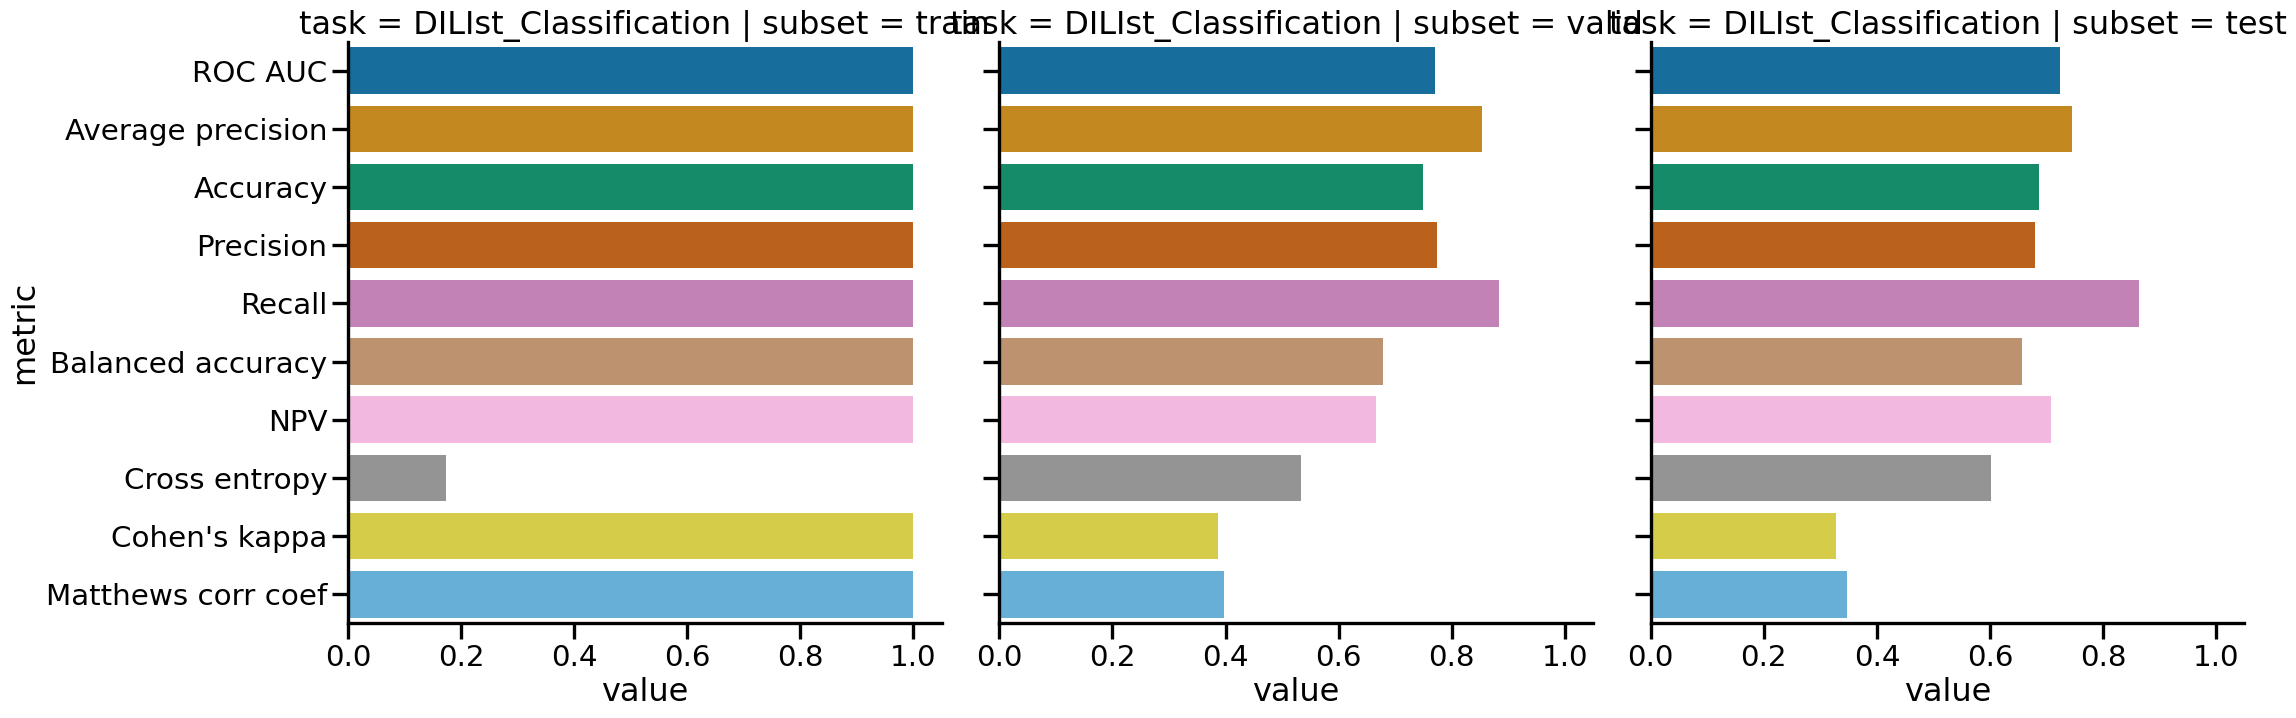

In [5]:
pp.plot_model_metrics('../AMPL_models/DILI_models2DILI_models/DILI_ch_moe_model_ac5b824c-60c3-48e7-a7eb-7d1e69350448.tar.gz', plot_size=8)

## Visualize Hyperparameters
There are several plotting functions in the `hyper_perf_plots` module that help visualize the different combinations of features for each type of model.

#### Examine overall scores
`plot_train_valid_test_scores()` gives a quick snapshot of your overall model performance. You can see if you overfitted and get a sense of whether your partitions are a good representation of future performance. Because the splitter can have a drastic effect on model performance, these plots are also separated by split type.

Here we see a fairly typical pattern where the training set metrics are higher than validation and test partitions. It is good to see that the validation and test scores are similar across many models, indicating that the models should generalize to new data well. For fingerprint splits, we see an odd trend where the model performs _better_ on the test set than the validation set (remember - we want to minimize MAE or RMSE!), suggesting that the split is problematic since the validation set does not necessarily  reflect the generalization capability of the model accurately.

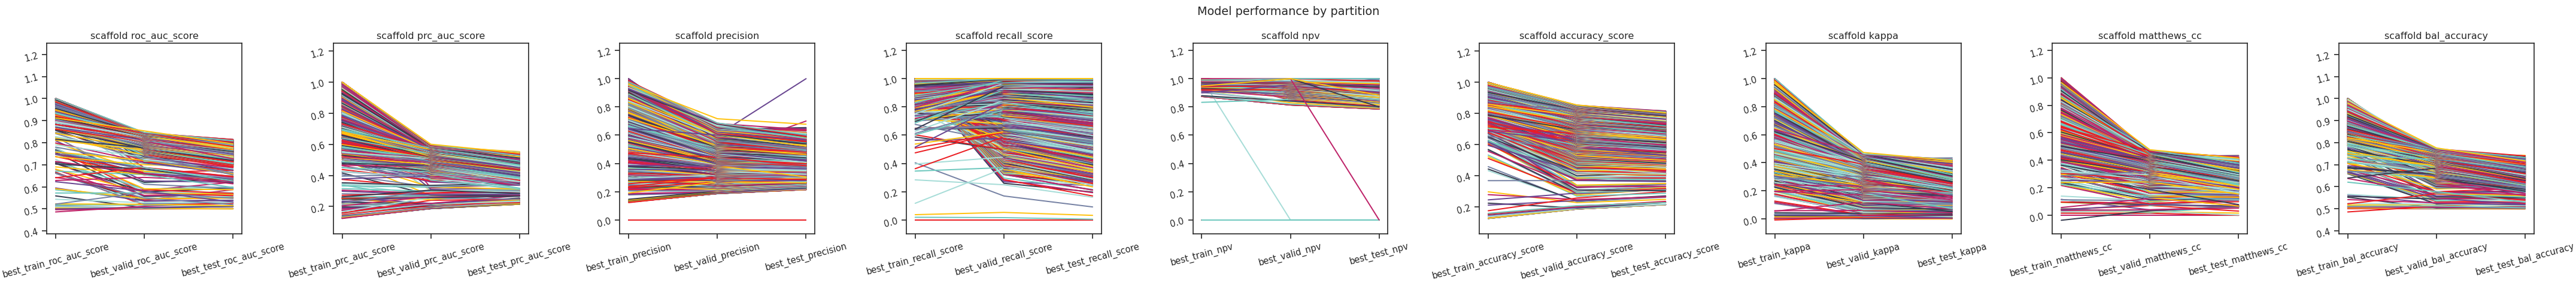

In [13]:
hpp.plot_train_valid_test_scores(result_df, prediction_type='classification')

#### Examine Splits

`plot_split_perf()` plots the performance of each split type, separated by feature type, for each performance metric. 

We can see that **fingerprint splits** perform much worse than **scaffold splits** for this dataset, and but **[RDKit](https://github.com/rdkit/rdkit)** and **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features perform differently. **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features work better for scaffold splits while **[RDKit](https://github.com/rdkit/rdkit)** features work better for **fingerprint splits**. Recalling the filtering from above, we know that **[RDKit](https://github.com/rdkit/rdkit)** features for **fingerprint splits** are only represented by **NN** models, which may skew these results.

In [ ]:
hpp.plot_split_perf(result_df, subset='valid')

#### General Model Features
We also want to understand general hyperparameters like model type and feature type and their effect on performance. We can use `plot_hyper_perf()` with `model_type='general'` as a shortcut to visualize these. 

We can see that **random forests** or **neural networks** perform the best while **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features perform better than **RDKit**. Additionally, the **random forest** models are very consistent while there is more variability in the **NN** and **XGBoost** model performance.

In [ ]:
hpp.plot_hyper_perf(result_df, model_type='general')

#### RF-specific Hyperparameters
We can also use `plot_hyper_perf()` to visualize model-specific hyperparameters. In this case we examine random forest models because they generally perform the best for this dataset.

Here, we can see two distinct sets of `valid_r2_scores` (probably from **fingerprint** vs **scaffold split** models), but both sets show similar trends. For `rf_estimators` it looks like 100-150 trees is optimal, while `rf_max_depth` does worse below ~15 and improves slowly after that. `rf_max_features` doesn't show a clear trend except that below 50 might result in worse models.

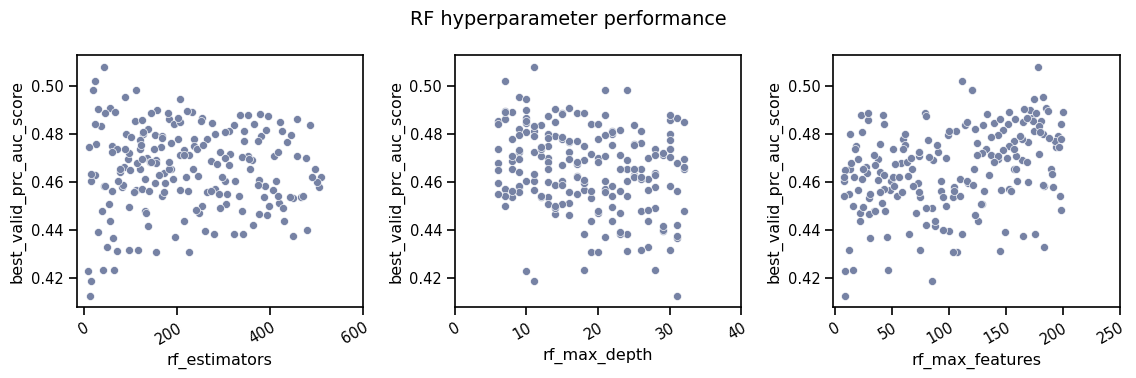

In [9]:
hpp.plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='prc_auc_score')

We can quickly get a list of scores to plot with `get_score_types()` and create the same plots with different metrics.

In [78]:
hpp.get_score_types()

Classification metrics:  ['roc_auc_score', 'prc_auc_score', 'precision', 'recall_score', 'npv', 'accuracy_score', 'kappa', 'matthews_cc', 'bal_accuracy']
Regression metrics:  ['r2_score', 'mae_score', 'rms_score']


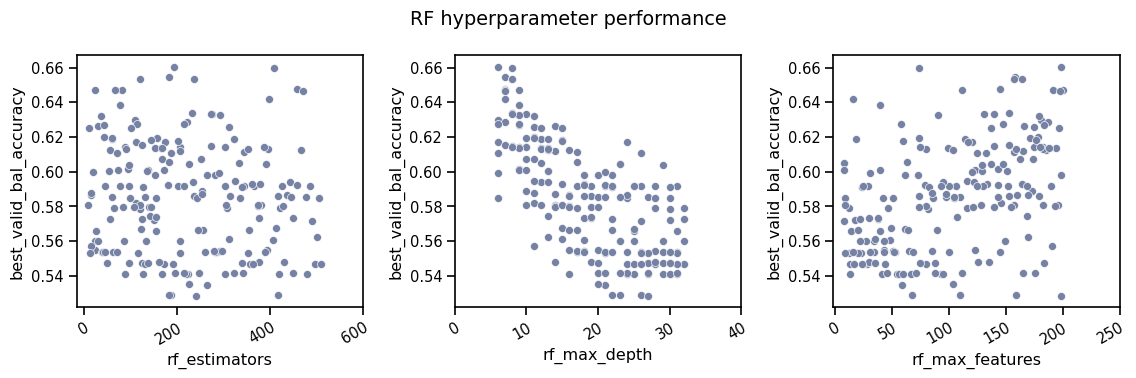

In [10]:
hpp.plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='bal_accuracy')

### NN Visualization
When visualizing hyperparameters of NN models in this case, it is slightly hard to see important trends because there is a large variance in their model performance. To avoid this, we use `plot_hyper_perf()` with a subsetted dataframe to look at a single combination of splitter and features. 

|Plot features|Description|
|---|---|
|`avg_dropout`|The average of dropout proportions across all layers of the model. This parameter can affect the generalizability and overfitting of the model and usually dropout of 0.1 or higher is best.|
|`learning_rate`|The learning rate during training. Generally, learning rates that are ~10e-3 do best.|
|`num_weights`|The product of layer sizes plus number of nodes in first layer, a rough estimate of total model size/complexity. This parameter should be minimized by selecting the smallest layer sizes possible that still maximize the preferred metric|
|`num_layers`|The number of layers in the NN, another marker of complexity. This should also be minimized.|
|`best_epoch`|Which epoch had the highest performance metric during training. This can indicate problematic training if the best_epochs are very small.|
|`max_epochs`|The max number of epochs the model was allowed to train (although "early stopping" may have occurred). If the max_epochs is too small you may underfit your model. This could be shown by all of your best_epochs being at max_epoch.|

In [ ]:
subsetted=result_df[result_df.splitter=='scaffold']
subsetted=subsetted[subsetted.features=='rdkit_raw']
hpp.plot_hyper_perf(subsetted, model_type='NN')

### XGBoost Visualization
Using `plot_xg_perf()`, we can simultaneously visualize the two most important parameters for **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** models - the learning rate and gamma. We can see that `xgb_learning_rate` should be between 0 and 0.45, after which the performance starts to deteriorate. There's no clear trend for `xgb_gamma`. We can additionally use `plot_hyper_perf()` to visualize more **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** parameters, but this is not shown here.

In [14]:
# hpp.plot_hyper_perf(result_df, model_type='xgboost')

In [ ]:
hpp.plot_xg_perf(result_df)

## Evaluation of a Single Model

After calling `compare_models.get_filesystem_perf_results()`, the dataframe can be sorted according to the score you care about. The column `model_parameters_dict` contains hyperparameters used for the best model. We can visualize this model using `perf_plots.plot_pred_vs_actual_from_file()`.

> **Note:** *Not all scores should be maximized. For example, `mae_score` or `rms_score` should be minimized instead.*

In [24]:
# exclude_features = ['moe']
# filtered_df = result_df[~result_df['features'].isin(exclude_features)]
winnertype='best_valid_bal_accuracy'

# result_df=cm.get_filesystem_perf_results(result_dir='dataset/SLC6A3_models/', pred_type='regression')
# result_df=pd.read_csv('dataset/SLC6A3_models/07_example_pred_df.csv', index_col=0)

result_df=result_df.sort_values(winnertype, ascending=False)
result_df[['model_type','features','splitter',"dropouts",'best_train_bal_accuracy','best_valid_bal_accuracy','best_test_bal_accuracy','model_uuid']].head()

,model_type,features,splitter,dropouts,best_train_bal_accuracy,best_valid_bal_accuracy,best_test_bal_accuracy,model_uuid
584,xgboost,ch_moe,scaffold,NaN,0.926986,0.726201,0.651507,3a63bb07-c9ce-4949-bf9a-3b88585eb243
552,xgboost,ch_moe,scaffold,NaN,0.838977,0.718008,0.640393,16c3fb30-c86e-4282-83e2-be16f4eb4a98
570,xgboost,ch_moe,scaffold,NaN,0.943960,0.717867,0.672969,8ea2617a-f363-49d3-9b6c-26308f254d89
297,xgboost,ch_mordred,scaffold,NaN,0.967501,0.717302,0.638030,daccde19-98b5-48e9-ad8f-aeb3ac644685
550,xgboost,ch_moe,scaffold,NaN,0.776478,0.714124,0.633815,1c4aee2e-cafe-4f8b-8860-cb8229d2593b


In [25]:
# exclude_features = ['moe']
# filtered_df = result_df[~result_df['features'].isin(exclude_features)]

winnertype='best_valid_prc_auc_score'
result_df=result_df.sort_values(winnertype, ascending=False)
result_df[['model_type','features','splitter',"dropouts",'best_train_prc_auc_score','best_valid_prc_auc_score','best_test_prc_auc_score','model_uuid']].head()

,model_type,features,splitter,dropouts,best_train_prc_auc_score,best_valid_prc_auc_score,best_test_prc_auc_score,model_uuid
575,xgboost,ch_moe,scaffold,NaN,0.959629,0.855691,0.724988,60e5fc56-2e3f-4773-adc1-d8c08459ba5d
537,xgboost,ch_moe,scaffold,NaN,0.987260,0.855266,0.717171,6f18eac4-864b-47df-a11f-490b7a276a5f
651,RF,ch_moe,scaffold,NaN,1.000000,0.854207,0.744855,ac5b824c-60c3-48e7-a7eb-7d1e69350448
578,xgboost,ch_moe,scaffold,NaN,0.999885,0.852882,0.752956,b100c953-a2b5-49d1-bf1c-b4991330f475
801,xgboost,ch_chemberta,scaffold,NaN,0.999988,0.852280,0.724240,433239f8-ae38-4ac5-bede-c298ece7b276


In [26]:
# exclude_features = ['moe']
# filtered_df = result_df[~result_df['features'].isin(exclude_features)]

winnertype='best_valid_roc_auc_score'
result_df=result_df.sort_values(winnertype, ascending=False)
result_df[['model_type','features','splitter',"dropouts",'best_train_roc_auc_score','best_valid_roc_auc_score','best_test_roc_auc_score','model_uuid']].head()

,model_type,features,splitter,dropouts,best_train_roc_auc_score,best_valid_roc_auc_score,best_test_roc_auc_score,model_uuid
651,RF,ch_moe,scaffold,NaN,1.000000,0.770551,0.722918,ac5b824c-60c3-48e7-a7eb-7d1e69350448
573,xgboost,ch_moe,scaffold,NaN,0.967666,0.765960,0.721896,0ffaa3a3-01f2-4047-81a5-fc75b4b38788
545,xgboost,ch_moe,scaffold,NaN,0.988240,0.763842,0.721002,6e3c9f37-8179-41c1-ae1c-9b4904e9e408
542,xgboost,ch_moe,scaffold,NaN,0.999940,0.763701,0.714103,fb5d0429-c24d-422c-a181-16e9cf907c94
530,xgboost,ch_moe,scaffold,NaN,0.978124,0.763559,0.706183,2b753613-1204-404b-a1f7-d3a5e104a76a


We can examine important parameters of the top model directly from the `result_df`. 

We see that through hyperparameter optimization, we have increased our `best_valid_r2_score` to 0.56, as compared to our baseline model `valid_r2_score` of 0.50011 (from **Tutorial 3, "Train a Simple Regression Model"**).

In [65]:
# result_df.iloc[0][['features','splitter','best_valid_roc_auc_score']]
result_df.iloc[0][['features','splitter','best_valid_roc_auc_score']]

features                    rdkit_raw
splitter                     scaffold
best_valid_roc_auc_score     0.827599
Name: 790, dtype: object

In [20]:
result_df.iloc[0].model_parameters_dict

'{"best_epoch": 16, "dropouts": [0.17007506488007712, 0.09570248192286951, 0.3606910069238921], "layer_sizes": [295, 454, 428], "learning_rate": 0.00713873552779967, "max_epochs": 100}'

In [22]:

result_df.iloc[0].model_path

'./ST_modelsMMP/MMP_models/MMP_tox21_curMoe_model_ad7aa1b8-4e18-4e83-9e2b-ceb3a535f4d1.tar.gz'

Here we use `plot_pred_vs_actual_from_file()` to visualize the prediction accuracy for the train, validation and test sets.

In [17]:
from atomsci.ddm.pipeline import compare_models

tar_path = "../AMPL_models/DILI_models/Optimize/DILI_ch_moe_model_4f4e6990-ef4a-4742-bf43-871316d0d801.tar.gz"

# For a classification model
perf_df, meta = compare_models.get_tarball_perf_table(
    model_tarball=tar_path,
    pred_type="classification",
)

print(perf_df)     # performance metrics (e.g., ROC AUC, PR AUC, etc.)
print(meta)        # metadata including model type, featurizer, hyperparameters

   train_roc_auc_score  train_prc_auc_score  train_precision  \
0                  1.0                  1.0              1.0   
1                  0.0                  0.0              0.0   

   train_recall_score  train_accuracy_score  train_npv  train_matthews_cc  \
0                 1.0                   1.0        1.0                1.0   
1                 0.0                   0.0        0.0                0.0   

   train_kappa  train_cross_entropy  train_confusion_matrix  \
0          1.0             0.172721  [[[334, 0], [0, 499]]]   
1          0.0             0.000000                       0   

   valid_roc_auc_score  valid_prc_auc_score  valid_precision  \
0             0.755862             0.846187         0.804688   
1             0.000000             0.000000         0.000000   

   valid_recall_score  valid_accuracy_score  valid_npv  valid_matthews_cc  \
0            0.858333              0.765363   0.666667           0.452607   
1            0.000000              0.0

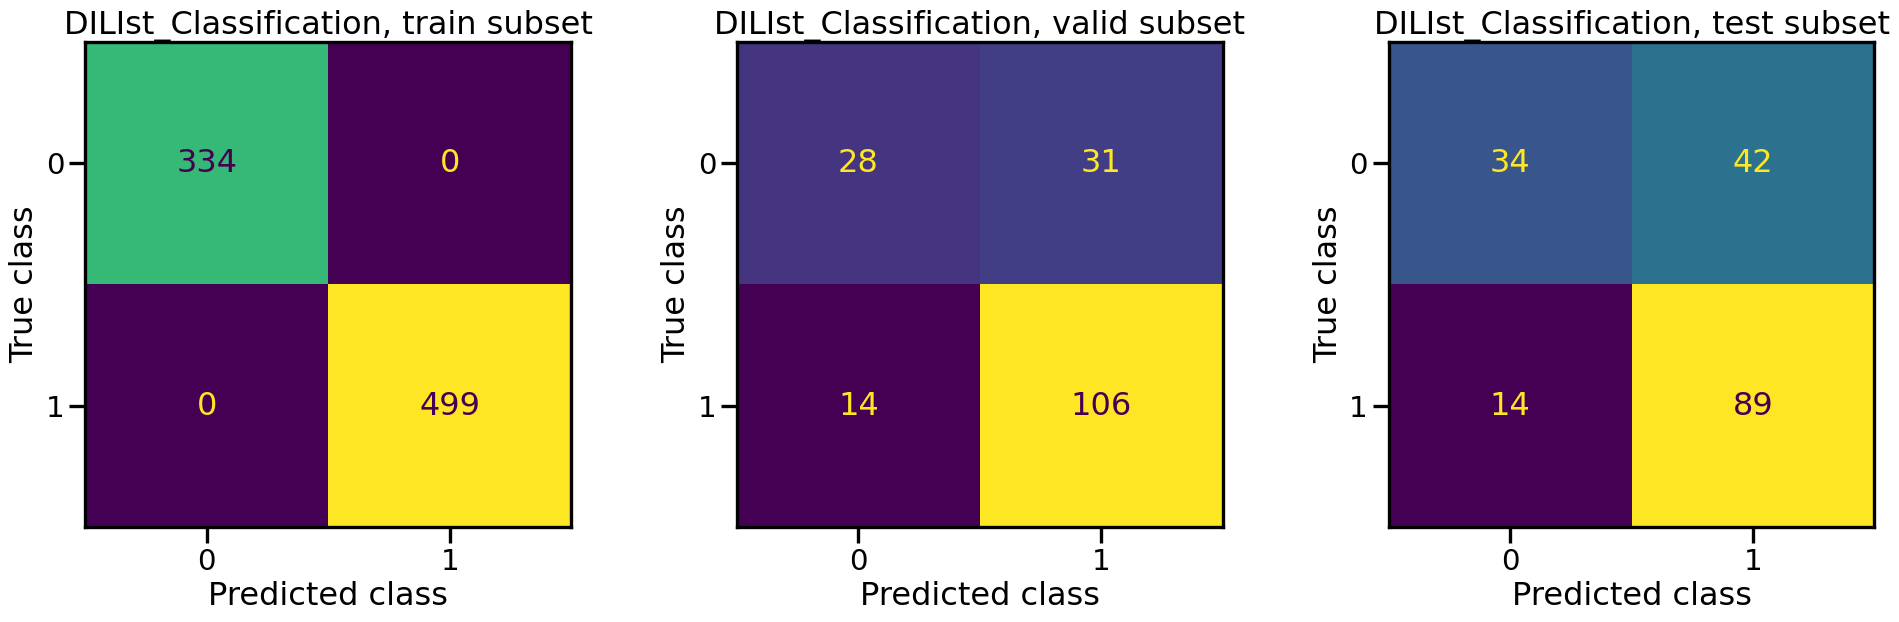

In [10]:
# plot best model, an NN
import importlib
from atomsci.ddm.pipeline import perf_plots as pp
# importlib.reload(pp)
# model_path=result_df.iloc[0].model_path
# model_path_prc='/Users/echun/repos/DILI/AMPL_models/ST_models/ROS_models/ROS_hits_up_class_curMoe_model_38d4ce36-93f2-45fc-947b-b5c4b5ff92b4.tar.gz' 

model_path_ec= '../AMPL_models/DILI_models2DILI_models/DILI_ch_moe_model_ac5b824c-60c3-48e7-a7eb-7d1e69350448.tar.gz'
pp.plot_confusion_matrices(model_path_ec)

This NN model looks like it isn't very good at predicting things with $pKi$ < 4.5. Additionally, there is a set of data at $pKi$=5 (this data is censored and all we know is that the compounds have a $pKi$ < 5 because higher concentrations of drug were not tested). This data is poorly predicted by the NN model.
> **Note:** *Be wary of selecting models only based on their performance metrics! As we can see, this NN has problems even though the r2_score is fairly high.*

In [ ]:
# plot best RF model
model_type='RF'
model_path=result_df[result_df.model_type==model_type].iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)
print('\nBest valid r2 score: ',result_df[result_df.model_type==model_type].iloc[0].best_valid_r2_score)
print('\nModel Parameters: ',result_df[result_df.model_type==model_type].iloc[0].model_parameters_dict,'\n')

This RF model looks like it did better at training than the best NN model, even though its performance validation score is slightly lower. The low $pKi$ values are learned more accurately in the training set, and the censored data at $pKi$=5 is also predicted more accurately.

In [ ]:
# plot best xgboost model
model_type='xgboost'
model_path=result_df[result_df.model_type==model_type].iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)
print('\nBest valid r2 score: ',result_df[result_df.model_type==model_type].iloc[0].best_valid_r2_score)
print('\nModel Parameters: ',result_df[result_df.model_type==model_type].iloc[0].model_parameters_dict,'\n')

This **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** model learns the low $pKi$ values better but still suffers from problems with predicting the censored data. 

Moving forward, we would select the **RF** model as the best performer.

In **Tutorial 7, "Train a Production Model"**, we will use the best-performing parameters to create a production model for the entire dataset.

If you have specific feedback about a tutorial, please complete the **[AMPL Tutorial Evaluation](https://forms.gle/pa9sHj4MHbS5zG7A6)**.